In [1]:
import pandas as pd
import sqlite3
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
# Завантаження даних
file_path = 'Retail_and_wherehouse_Sale.csv'
data = pd.read_csv(file_path)

# Перевірка на пропущені значення
print("Пропущені значення в даних:")
print(data.isnull().sum())

# Видалення рядків із пропусками в колонці SUPPLIER
data = data.dropna(subset=['SUPPLIER'])

# Заповнення пропусків у числових колонках середніми значеннями
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].apply(lambda x: x.fillna(x.mean()))

# Перевірка пропусків після очищення
print("Пропущені значення після заповнення:")
print(data.isnull().sum())

Пропущені значення в даних:
YEAR                 0
MONTH                0
SUPPLIER            33
ITEM_CODE            0
ITEM_DESCRIPTION     0
ITEM_TYPE            0
RETAIL_SALES         1
RETAIL_TRANSFERS     0
WAREHOUSE_SALES      0
dtype: int64
Пропущені значення після заповнення:
YEAR                0
MONTH               0
SUPPLIER            0
ITEM_CODE           0
ITEM_DESCRIPTION    0
ITEM_TYPE           0
RETAIL_SALES        0
RETAIL_TRANSFERS    0
WAREHOUSE_SALES     0
dtype: int64


In [3]:
db_path = 'sales_database.db'
db_connection = sqlite3.connect(db_path)
cursor = db_connection.cursor()

# Завантаження даних у таблицю sales_data
data.to_sql('sales_data', db_connection, if_exists='replace', index=False)
print("Дані успішно завантажені у таблицю 'sales_data'.")

Дані успішно завантажені у таблицю 'sales_data'.


In [11]:
# Вибір ознак і цільової змінної
features = data[['YEAR', 'MONTH', 'ITEM_TYPE', 'WAREHOUSE_SALES', 'RETAIL_TRANSFERS']]
target = data['RETAIL_SALES']

# Розділення даних на тренувальні та тестові
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Перетворення категоріальних даних у числові
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['YEAR', 'MONTH', 'WAREHOUSE_SALES', 'RETAIL_TRANSFERS']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ITEM_TYPE']),
    ])

# Побудова пайплайна з лінійною регресією
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Навчання моделі на тренувальних даних
model.fit(X_train, y_train)

# Прогнозування на тестових даних
predictions = model.predict(X_test)

# Обчислення метрик
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
r2_cross = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1).mean()

print("Mae:" ,mae)
print("MSE:" ,mse)
print("R2:" ,r2)
print("R2_cross:" ,r2_cross)


Mae: 1.808654755015432
MSE: 40.45816576456701
R2: 0.9478793776908776
R2_cross: 0.9470498374946825


Результати успішно оновлені у таблиці 'result'.


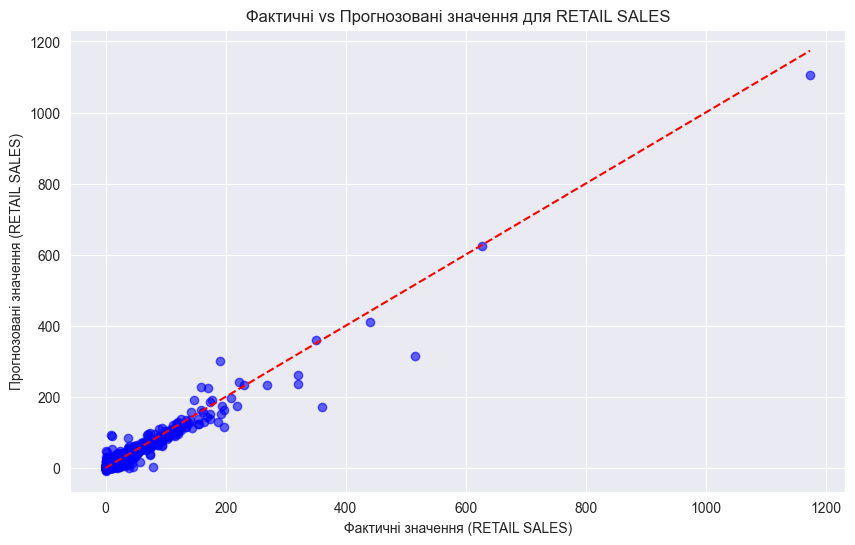

Аналіз завершено, з'єднання з базою даних закрито.


In [9]:
# Очистка таблиці result перед записом нових даних
cursor.execute('DELETE FROM result')
db_connection.commit()

# Створення таблиці result (якщо ще не існує)
cursor.execute('''
    CREATE TABLE IF NOT EXISTS result (
        metric_name TEXT,
        metric_value REAL
    )
''')

# Запис метрик у таблицю result
metrics = [('MAE', mae), ('MSE', mse), ('R²', r2), ("R² через крос-валідацію", r2_cross)]
cursor.executemany('INSERT INTO result (metric_name, metric_value) VALUES (?, ?)', metrics)
db_connection.commit()
print("Результати успішно оновлені у таблиці 'result'.")

# Візуалізація результатів
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Фактичні значення (RETAIL SALES)')
plt.ylabel('Прогнозовані значення (RETAIL SALES)')
plt.title('Фактичні vs Прогнозовані значення для RETAIL SALES')
plt.show()

# Закриття з'єднання з базою даних
db_connection.close()
print("Аналіз завершено, з'єднання з базою даних закрито.")